##Implementing Trading strategies using ML

We have seen how a stock universe is created through the analysis of stock-price data. It was then applied in momentum trading. 

In this notebook, we will see how an ML model can be made to implement the trading strategy, and back-test it using the Auquan toolbox, to see the performance.

In [1]:
import scipy
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

Importing the libraries and the toolbox. Through it, we can obtain the data (stock bid price, ask price, bid volume, ask volume, future bid price etc.) loaded in a dictionary of dataframes.

In [2]:
!pip install -U auquan_toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 9.4 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=d31b9355125ba5050f487dcac9175d02790be9cdeade7578ac0db9719c9b340c
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [3]:
from backtester.dataSource.csv_data_source import CsvDataSource

First we need to run ```!pip install -U auquan_toolbox``` otherwise the backtester libraries won't be identified.

In [4]:
cachedFolderName = '/data/'
dataSetId = 'trainingData1'
startDate = '2017/01/06'
endDate = '2017/02/09'
instrumentIds = ['MQK']
downloadUrl = 'https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data'

ds = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr=startDate,
                             endDateStr=endDate,
                             liveUpdates=False,
                             pad=True)

https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData1/stock_list.txt
Processing data for stock: MQK


Here we use the MQK ticker, which follows real-world price data but is not an actual ticker itself. 

In [5]:
ds.getInstrumentIds()

['MQK']

Let's see the book data features that have been loaded.

In [6]:
ds.getBookDataFeatures()

['stockVWAP',
 'futureVWAP',
 'basis',
 'stockTopBidVol',
 'stockTopAskVol',
 'stockTopBidPrice',
 'stockTopAskPrice',
 'futureTopBidVol',
 'futureTopAskVol',
 'futureTopBidPrice',
 'futureTopAskPrice',
 'stockNextBidVol',
 'stockNextAskVol',
 'stockNextBidPrice',
 'stockNextAskPrice',
 'futureNextBidVol',
 'futureNextAskVol',
 'futureNextBidPrice',
 'futureNextAskPrice',
 'stockTotalBidVol',
 'stockTotalAskVol',
 'futureTotalBidVol',
 'futureTotalAskVol',
 'stockAverageBidPrice',
 'stockAverageAskPrice',
 'futureAverageBidPrice',
 'futureAverageAskPrice',
 'FairValue',
 'benchmark_score']

Now we load the data in the proper format.

In [7]:
def loadData(ds, id):
    data = ds._bookDataByInstrument[id].getBookData()

    data['Stock Price'] =  data['stockTopBidPrice'] +\
                           data['stockTopAskPrice'] / 2.0
    data['Future Price'] = data['futureTopBidPrice'] +\
                           data['futureTopAskPrice'] / 2.0
    data['Y(Target)'] = data['basis'].shift(-5)
    del data['benchmark_score']
    del data['FairValue']
    return data

data = loadData(ds,instrumentIds[0])

Let's see how the data appears.

In [8]:
data.head()

,stockVWAP,futureVWAP,basis,stockTopBidVol,stockTopAskVol,stockTopBidPrice,stockTopAskPrice,futureTopBidVol,futureTopAskVol,futureTopBidPrice,...,stockTotalAskVol,futureTotalBidVol,futureTotalAskVol,stockAverageBidPrice,stockAverageAskPrice,futureAverageBidPrice,futureAverageAskPrice,Stock Price,Future Price,Y(Target)
2017-01-06 09:17:00,517.773,512.492,5.425,79.0,79.0,518.00,518.30,4000.0,2000.0,512.60,...,2780.0,12000.0,12000.0,517.493,518.654,512.000,513.142,777.150,769.025,5.625
2017-01-06 09:18:00,515.300,510.682,4.425,40.0,10.0,515.05,515.30,2000.0,4000.0,510.65,...,1756.0,10000.0,24000.0,514.919,515.708,510.340,511.283,772.700,766.075,5.400
2017-01-06 09:19:00,516.225,511.342,4.950,81.0,1496.0,516.20,516.45,2000.0,2000.0,511.25,...,3010.0,10000.0,14000.0,515.986,516.488,511.050,511.650,774.425,767.000,5.450
2017-01-06 09:20:00,519.792,513.959,5.650,179.0,1940.0,519.65,519.95,2000.0,2000.0,514.05,...,3530.0,10000.0,12000.0,519.549,520.079,513.470,514.650,779.625,771.175,5.175
2017-01-06 09:21:00,520.270,513.819,6.400,68.0,93.0,520.45,520.60,2000.0,6000.0,513.85,...,2128.0,12000.0,24000.0,520.022,520.756,513.392,514.775,780.750,771.050,5.050


Above, VWAP is volume weighted average price. 

Now, we have 3 datasets, train, validation and test.

In [9]:
# Training Data
dataSetId =  'trainingData1'
ds_training = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)

training_data = loadData(ds_training, instrumentIds[0])

# Validation Data
dataSetId =  'trainingData2'
ds_validation = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)

validation_data = loadData(ds_validation, instrumentIds[0])

#Testing Data
dataSetId = 'trainingData3'
ds_test = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)
out_of_sample_test_data = loadData(ds_test, instrumentIds[0])

Processing data for stock: MQK
https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData2/stock_list.txt
Processing data for stock: MQK
https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData3/stock_list.txt
Processing data for stock: MQK


Now we add the target variable Y, which is defined as the average of the next 5 values of the basis.

In [10]:
def prepareData(data, period):
    data['Y(Target)'] = data['basis'].rolling(period).mean().shift(-period)
    if 'FairValue' in data.columns:
        del data['FairValue']
    data.dropna(inplace=True)

period = 5
prepareData(training_data, period)
prepareData(validation_data, period)
prepareData(out_of_sample_test_data, period)

Now we'll create some functions required for feature engineering.

In [11]:
def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0)

def ewm(dataDf, halflife):# exponentially weighted moving averages.
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

# relative strength index
def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

The predictive power should mainly come from the features and not from which ML model is chosen. We should explore the relationship with target variable.
So here we create many features. (We won't actually use all of them)

In [12]:
def create_features(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [ 'emabasis3','emabasis5','emabasis2','emabasis7','emabasis10',\
                                                             'emabasis4','rsi15','rsi10','rsi5','mom1','mom10',\
                                                             'mom3','mom5'])
    
    basis_X['mom1'] = difference(data['basis'],2)
    basis_X['mom3'] = difference(data['basis'],4)
    basis_X['mom5'] = difference(data['basis'],6)
    basis_X['mom10'] = difference(data['basis'],11)

    basis_X['rsi15'] = rsi(data['basis'],15)
    basis_X['rsi10'] = rsi(data['basis'],10)
    basis_X['rsi5'] = rsi(data['basis'],5)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis3'] = ewm(data['basis'],3)
    basis_X['emabasis4'] = ewm(data['basis'],4)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis7'] = ewm(data['basis'],7)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']
    basis_X['vwapbasis'] = data['stockVWAP']-data['futureVWAP']
    
    basis_X['swidth'] = data['stockTopAskPrice']-data['stockTopBidPrice']
    basis_X['fwidth'] = data['futureTopAskPrice']-data['futureTopBidPrice']
    
    basis_X['btopask'] = data['stockTopAskPrice']-data['futureTopAskPrice']
    basis_X['btopbid'] =data['stockTopBidPrice']-data['futureTopBidPrice']
    basis_X['bavgask'] = data['stockAverageAskPrice']-data['futureAverageAskPrice']
    basis_X['bavgbid'] = data['stockAverageBidPrice']-data['futureAverageBidPrice']
    basis_X['bnextask'] = data['stockNextAskPrice']-data['futureNextAskPrice']
    basis_X['bnextbid'] = data['stockNextBidPrice']-data['futureNextBidPrice']
    basis_X['topaskvolratio'] = data['stockTopAskVol']/data['futureTopAskVol']
    basis_X['topbidvolratio'] = data['stockTopBidVol']/data['futureTopBidVol']
    basis_X['totalaskvolratio'] = data['stockTotalAskVol']/data['futureTotalAskVol']
    basis_X['totalbidvolratio'] = data['stockTotalBidVol']/data['futureTotalBidVol']
    basis_X['nextbidvolratio'] = data['stockNextBidVol']/data['futureNextBidVol']
    basis_X['nextaskvolratio'] = data['stockNextAskVol']-data['futureNextAskVol']
    
    basis_X['emabasisdi4'] = basis_X['emabasis7'] - basis_X['emabasis5'] + basis_X['emabasis2']
    basis_X['emabasisdi1'] = basis_X['emabasis10'] - basis_X['emabasis5'] + basis_X['emabasis3']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    basis_X['emabasisdi5'] = basis_X['emabasis7']- basis_X['emabasis5'] + data['basis']
    basis_X['emabasisdi'] = basis_X['emabasis5'] - basis_X['emabasis3'] + data['basis']
    basis_X['emabasisdi2'] = basis_X['emabasis10'] - basis_X['emabasis5']+ data['basis']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

In [13]:
basis_X_train, basis_y_train = create_features(training_data)
basis_X_test, basis_y_test = create_features(validation_data)


Any null data in y: False, X: False
Length y: 8737, X: 8737
Any null data in y: False, X: False
Length y: 6499, X: 6499


Now comes the model selection.
We'll start with linear regression (without normalizing the features)
Here we are avoiding normalization because the range of future data is not known.

In [14]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linreg_model(basis_X_train, basis_y_train, basis_X_test, basis_y_test):
    reg1 = linear_model.LinearRegression()
    #now train the model 
    reg1.fit(basis_X_train, basis_y_train)

    basis_y_pred = reg1.predict(basis_X_test)
    #The coefficients
    print('Coefficients: \n', reg1.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(basis_y_test, basis_y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

    # Plot outputs
    plt.scatter(basis_y_pred, basis_y_test,  color='black')
    plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

    plt.xlabel('Y(actual)')
    plt.ylabel('Y(Predicted)')

    plt.show()
    
    return reg1, basis_y_pred

Coefficients: 
 [ 2.74107353e+08 -1.41418412e+08 -3.84099394e+07 -6.45985367e+07
 -2.26967814e+07 -5.64845077e+01 -1.04203632e-03 -6.17865481e-04
 -8.06321842e-05  4.34515647e-02  1.16537926e-02  5.76111060e-02
 -3.06278406e-02 -5.06312848e+07  8.39786415e-02  4.39934768e-03
 -6.81089520e-03 -5.06312848e+07 -5.06312848e+07  6.47809130e-02
  5.72195492e-02  2.85191926e-03  1.58460758e-02 -7.62531510e-03
 -7.64544999e-04 -3.87711584e-02  3.12702874e-02  3.41577706e-03
 -1.34152096e-06  3.84099357e+07 -1.30942985e+08  8.55494224e+07
  2.61885903e+07  5.76149190e+07  6.80903456e+07]
Mean squared error: 0.02
Variance score: 0.96


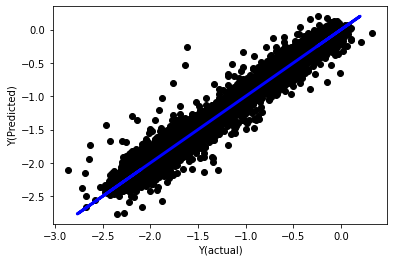

In [15]:
lin_reg, basis_y_pred = linreg_model(basis_X_train, basis_y_train, basis_X_test,basis_y_test)

A higher r2 score generally implies that the fitting is better. We can try other models too, here we try a tree regression model.

Mean squared error: 0.02
Variance score: 0.96


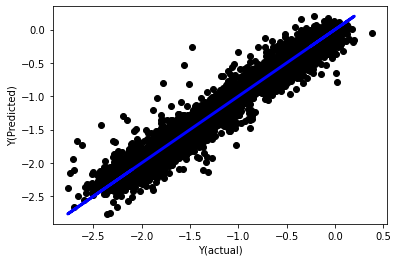

In [16]:
from sklearn import ensemble

treereg = ensemble.ExtraTreesRegressor()
treereg.fit(basis_X_train, basis_y_train)
basis_y_pred = treereg.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_trees = basis_y_pred.copy()

some of the features are highly correlated with others. So we take lesser number of features, by ignoring those that were just linear combinations of other features.

In [17]:
def make_features_again(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [])
    
    basis_X['mom10'] = difference(data['basis'],11)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']

    basis_X['totalaskvolratio'] = (data['stockTotalAskVol']-data['futureTotalAskVol'])/100000
    basis_X['totalbidvolratio'] = (data['stockTotalBidVol']-data['futureTotalBidVol'])/100000
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

In [18]:
basis_X_test, basis_y_test = make_features_again(validation_data)
basis_X_train, basis_y_train = make_features_again(training_data)


Any null data in y: False, X: False
Length y: 6499, X: 6499
Any null data in y: False, X: False
Length y: 8737, X: 8737


Mean squared error: 0.02
Variance score: 0.96


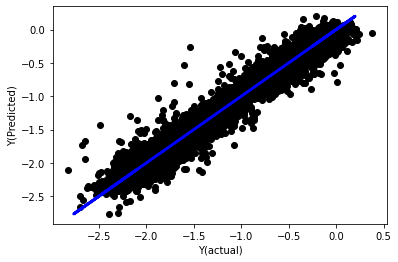

In [20]:
#make tree model with this new smaller set of features
treereg2 = ensemble.ExtraTreesRegressor()
treereg2.fit(basis_X_train, basis_y_train)
basis_y_pred2 = treereg2.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred2, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_trees2 = basis_y_pred2.copy()

The performance of the model didn't get affected, despite using lesser features than the previous one.

We can save this model now using pickle, for later use. Here we save the tree-regressor model.

In [21]:
import pickle
filename = 'MQKmodel.pkl'

with open(filename, 'wb') as handle:
    pickle.dump(treereg2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Now we use the test data to see how our model performs on unseen data.
The auquan toolbox can be used to simulate and control a trading system very well.

In [22]:
from backtester.trading_system import TradingSystem
from backtester.trading_system_parameters import TradingSystemParameters
from backtester.features.feature import Feature
from backtester.executionSystem.simple_execution_system_fairvalue import SimpleExecutionSystemWithFairValue
from backtester.orderPlacer.backtesting_order_placer import BacktestingOrderPlacer
from backtester.constants import *
from backtester.timeRule.us_time_rule import USTimeRule
from backtester.logger import *

In [28]:
class MyTradingParams(TradingSystemParameters):
    def __init__(self):
        super(MyTradingParams, self).__init__()
        self.count = 0 
        self.params = {}
        self.start = '2017/01/06'
        self.end = '2017/01/10'
        self.instrumentIds = ['MQK']
        filename = 'MQKmodel.pkl'
        with open(filename, 'rb') as handle:
            b = pickle.load(handle)
        self.model = {'MQK': b}
        self.updateFrequency = 1

    '''
    Returns an instance of class DataParser. Source of data for instruments
    '''

    def getDataParser(self):
        dataSetId = 'trainingData3'
        downloadUrl = 'https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data'
        
        z_data = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=self.instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = '',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr=self.start,
                             endDateStr=self.end,
                             liveUpdates=True,
                             pad=True)
        return z_data


    def getTimeRuleForUpdates(self):
        return USTimeRule(startDate = self.start,
                        endDate = self.end,
                        startTime='9:30',
                        endTime='15:30',
                        frequency='M', sample='1')

    
    '''
    Return starting capital
    '''
    def getStartingCapital(self):
        return 10000
    
    def getPrediction(self, time, updateNum, instrumentManager):

        predictions = pd.Series(0.0, index = self.instrumentIds)

        # holder for all the instrument features
        lbInstF = instrumentManager.getLookbackInstrumentFeatures()

        # to get to the most recent datapoints, the last row of the dataframe is taken
        mom10 = lbInstF.getFeatureDf('mom10').iloc[-1]
        emabasis2 = lbInstF.getFeatureDf('emabasis2').iloc[-1]
        emabasis5 = lbInstF.getFeatureDf('emabasis5').iloc[-1]
        emabasis10 = lbInstF.getFeatureDf('emabasis10').iloc[-1] 
        basis = lbInstF.getFeatureDf('basis').iloc[-1]
        totalaskvol = (lbInstF.getFeatureDf('stockTotalAskVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalAskVol').iloc[-1])/100000.0
        totalbidvol = (lbInstF.getFeatureDf('stockTotalBidVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalBidVol').iloc[-1])/100000.0
        
        # implementing the tree
        featureList = [mom10, emabasis2, emabasis5, emabasis10,
                      basis, totalaskvol, totalbidvol]
        for s in self.instrumentIds:
            Y = lbInstF.getFeatureDf('FairValue')[s]
            #Creating a dataframe to hold features for this stock
            X = pd.DataFrame(index=Y.index, columns=range(len(featureList)))         #DF with rows=timestamp and columns=featureNames
            for i in range(len(featureList)):
                X[i] = featureList[i][s]

            # if this is the first time we are training a model, start by creating a new model
            # we will update the model during further runs
            #if s not in self.model:
            if len(self.model) == 0:
                self.model[s] = ensemble.ExtraTreesRegressor()

            # if we are at the update frequency, update the model
            if (updateNum%self.updateFrequency==0) and (updateNum>59):

                # drop nans and infs from X
                X = X.replace([np.inf, -np.inf], np.nan).dropna()
                # create a target variable vector for this stock, with same index as X
                y_s = Y.loc[Y.index.isin(X.index)]

                print('Training...')
                # make numpy arrays with the right shape
                x_train = np.array(X)[:-1]                         # shape = timestamps x numFeatures
                y_train = np.array(y_s)[:-1].astype(int).reshape(-1) # shape = timestamps x 1
                self.model[s].fit(x_train, y_train)

            if (updateNum)<60:#self.updateFrequency:
                # we haven't trained a model yet
                predictions[s] = np.nan
            else:
                # make your prediction using your model
                if X.iloc[-1].replace([np.inf, -np.inf], np.nan).hasnans:
                    # first verify none of the features are nan or inf
                    print('Test Feature Data has nans')
                    predictions[s] = np.nan
                else:
                    predictions[s] = self.model[s].predict(X.iloc[-1].values.reshape(1,-1))

        
        predictions.fillna(emabasis5,inplace=True)
        
        print('Current basis: %.3f, predicted basis: %.3f'%(basis['MQK'], predictions['MQK']))
        if updateNum>1:
            print('Current position: %.0f'%lbInstF.getFeatureDf('position').iloc[-1]['MQK'])

        return predictions

        #return predictions

    def getCustomFeatures(self):
        return {'prediction': TrainingPredictionFeature}

    def getInstrumentFeatureConfigDicts(self):

        predictionDict = {'featureKey': 'prediction',
                                'featureId': 'prediction',
                                'params': {}}

        # Adding relevant features
        expma5dic = {'featureKey': 'emabasis5',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 5,
                              'featureName': 'basis'}}
        expma10dic = {'featureKey': 'emabasis10',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 10,
                              'featureName': 'basis'}}                     
        expma2dic = {'featureKey': 'emabasis2',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 2,
                              'featureName': 'basis'}}
        mom10dic = {'featureKey': 'mom10',
                 'featureId': 'difference',
                 'params': {'period': 10,
                              'featureName': 'basis'}}
        scoreDict = {'featureKey': 'score',
                     'featureId': 'score_fv',
                     'params': {'predictionKey': 'prediction',
                                'price': 'FairValue'}}
        return {INSTRUMENT_TYPE_STOCK: [expma5dic,expma2dic,expma10dic,mom10dic,
                                        predictionDict, scoreDict]}

    # '''
    # Returns an array of market feature config dictionaries
    # '''
    def getMarketFeatureConfigDicts(self):
    # Adding relevant features
        scoreDict = {'featureKey': 'score',
                     'featureId': 'score_fv',
                     'params': {'featureName': self.getPriceFeatureKey(),
                                'instrument_score_feature': 'score'}}
        return [scoreDict]

    '''convert the predictions to intended positions for the features'''
    def getExecutionSystem(self):
        return SimpleExecutionSystemWithFairValue(enter_threshold_deviation=0.5, exit_threshold_deviation=0.2, 
                                                longLimit=250, shortLimit=250, capitalUsageLimit=0.05, 
                                                enterlotSize=10, exitlotSize=10, 
                                                limitType='L', price=self.getPriceFeatureKey())

    def getOrderPlacer(self):
        return BacktestingOrderPlacer()

    '''
    Returns the amount of lookback data you want for your calculations.
    '''

    def getLookbackSize(self):
        return 90


    def getPriceFeatureKey(self):
        return 'basis'


    def getMetricsToLogRealtime(self):
        # Everything will be logged if left as is
        return {
            'market': None,
            'instruments': None
        }
        
class TrainingPredictionFeature(Feature):

    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
        t = MyTradingParams()
        return t.getPrediction(time, updateNum, instrumentManager)

In [29]:
tsParams = MyTradingParams()

trad_system = TradingSystem(tsParams)
    
results = trad_system.startTrading(onlyAnalyze=False, shouldPlot=False, makeInstrumentCsvs=False)
# Set onlyAnalyze to True to generate csv files with all the features.
# Set onlyAnalyze to False to run a full backtest


Processing data for stock: MQK
Logging all the available market metrics in tensorboard
Logging all the available instrument metrics in tensorboard
2017-01-06 09:30:00
Current basis: 3.685, predicted basis: 3.685
2017-01-06 09:31:00
Current basis: 3.815, predicted basis: 3.702
Current position: 0
2017-01-06 09:32:00
Current basis: 3.812, predicted basis: 3.716
Current position: 0
2017-01-06 09:33:00
Current basis: 3.661, predicted basis: 3.709
Current position: 0
2017-01-06 09:34:00
Current basis: 3.811, predicted basis: 3.722
Current position: 0
2017-01-06 09:35:00
Current basis: 3.987, predicted basis: 3.756
Current position: 0
2017-01-06 09:36:00
Current basis: 4.011, predicted basis: 3.789
Current position: 0
2017-01-06 09:37:00
Current basis: 4.041, predicted basis: 3.822
Current position: 0
2017-01-06 09:38:00
Current basis: 4.397, predicted basis: 3.896
Current position: 0
2017-01-06 09:39:00
Current basis: 4.343, predicted basis: 3.954
Current position: 0
2017-01-06 09:40:00
Cur

Now we can see the results from the backtest. The toolbox tells us the pnl from the trading strategy, and other metrics.

In [30]:
results

{'instrument_names': ['MQK'],
 'instrument_stats': [{'pnl': {'MQK': 0.11692330000000006},
   'score': {'MQK': 0.5270070414825269}}],
 'pnl': 0.11692330000000006,
 'trading_days': 3,
 'score': 0.5270070414825269,
 'total_loss': 4699.115000000002,
 'variance': 790.2561871673435,
 'total_profit': 5868.347999999998,
 'capitalUsage': 1324.7970000000041,
 'portfolio_value': 11169.233,
 'capital': 9936.30299999999,
 'maxDrawdown': 483.66499999999905,
 'maxPortfolioValue': 11230.483,
 'count_loss': 222,
 'count_profit': 228}

The results show us a positive pnl. 

However we see that the performance on the training data was better than that on the test data, since the new mean squared error is higher.